In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
import tensorflow as tf
import math
import time

# improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

In [2]:
# Import and organize data

filepath = "/Users/salatiemann/Documents/UC Berkeley/Year 3 Sem 2 (Spring 2020)/Tensegrity-HRI/Data_sala/test"
test_numbers = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20',
      '21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40',
      '41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60',
      '61','62','63','64','65','66','67','68','69','70','71','72']
data = []
data_no_acc = []
for num in test_numbers:
    filename = filepath + num + '.csv'
    d = pd.read_csv(filename, names = ["time", "IND", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", 
                                   "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12","ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d.drop(columns = ["IND", "time"])
    d2 = d1.drop(columns = ["ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d1.to_numpy()
    d1 = d1[0:7000]
    data.append(d1)
    d2 = d2.to_numpy()
    d2 = d2[0:7000]
    data_no_acc.append(d2)

In [3]:
labels = [0,0,0,3,1,1,1,1,1,1,3,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,1,1,1,1,0,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,2,3,3,3,3,3,2,2,2,0,0,1,1,2,2,3,3]

In [4]:
np.shape(labels)
labels = np.asarray(labels)

In [5]:
print(np.shape(data))

(72, 7000, 15)


In [6]:
# This feature returns the percent of data points that are below 75% of the max

def three_quarters(column,percent):
    max = np.max(column)
    three_fourths = percent*max
    e = []
    j=0
    for i in range(len(column)):
        if column[i] <= .75*np.max(column):
            j+=1
    return j/len(column)

In [28]:
# This feature takes the max of each column, takes the data point [change_factor] ms after that, and then normalizes 
# the difference

def change_in_max(column, change_factor):
    max_index = np.argmax(column)
    minus_change_index = max_index - change_factor
    if minus_change_index > 0:
        minus_change_value = column[minus_change_index]
    else:
        minus_change_index = max_index + change_factor
        minus_change_value = column[minus_change_index]
    diff = np.max(column) - minus_change_value
    normalized = diff/np.std(column)
    return normalized

In [29]:
# This function takes all 72 data points of size (7001,16) and puts them into a feature-engineered array.
# Desired shape: 72 data points of size (6,16) --> (72,6,16)

def features(array, three_quarters_percent, change_in_max_change_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    number_of_features = 6
    condensed_data = np.zeros((len_dataset,number_of_features,number_of_columns))
    for j in range(72):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((number_of_features,number_of_columns),dtype=np.float64)
        for i in range(number_of_columns):
            column = data_point[:,i]
            D[0,i] = np.mean(column)
            D[1,i] = np.var(column)
            D[2,i] = np.max(column)-np.min(column)
            D[3,i] = three_quarters(column,three_quarters_percent)
            D[4,i] = change_in_max(column,change_in_max_change_factor)
            D[5,i] = np.sum(column)/np.max(column) #or np.std(column). MAX WORKS THE BEST! went from 80% or so to 100%
        condensed_data[j]=D
        if np.mod(j,6) == 0:
            print(j, end=" ")
    return condensed_data

In [30]:
# Condense data into averages over a specified number of data points

def condense(array):
    len_dataset, _, number_of_columns = np.shape(array)
    length = len(array[0])
    condense_factor = 5
    condensed_length = int((length/condense_factor))
    condensed_data = np.zeros((len_dataset,condensed_length,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        for k in range(number_of_columns):
            column = data_point[:,k]
            for i in range(condensed_length):
                condensed_data[j][i,k] = np.mean(column[i*condense_factor:(i*condense_factor+condense_factor)])
            print(".", end="")
    return condensed_data

In [50]:
# Feature-ify the data

featured_data = features(data,.75,50)
np.shape(featured_data)

0 6 12 18 24 30 36 42 48 54 60 66 

(72, 6, 15)

In [32]:
# Condense the data (on non-feature-ified data)

condensed_data = condense(data)
np.shape(condensed_data)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

(72, 1400, 15)

In [51]:
# Takes the max of all features from the 16 datapoints. Output is 72 sets of 1 by 6 data, where each of the 6 points
# is the max of each feature from the set. 

def everything_max(array):
    len_dataset, num_features, num_datapoints = np.shape(array)
    maxed_data = np.zeros((len_dataset, 1, num_features))
    for i in range(len_dataset):
        datapoint = array[i]
        D = np.zeros((1, num_features))
        for j in range(num_features):
            D[0,j] = max(datapoint[:,j])
        maxed_data[i] = D
    return maxed_data

In [52]:
# Make model

def make_model(dataset,num_train):
    nsamples, nx, ny = np.shape(dataset)
    reformated_data = np.reshape(dataset,(nsamples,nx*ny))
    
    train = reformated_data[0:num_train]
    test = reformated_data[num_train:nsamples]
    train_labels = labels[0:num_train]
    test_labels = labels[num_train:nsamples]
    
    # Return percent of correct labels
    def percent_correct(test_dataset, test_labels):
        total = 0
        a = model.predict(test_dataset)
        for i in range(len(a)):
            if a[i] == test_labels[i]:
                total += 1
        correct = total/len(a)*100
        return correct
    
    model = GaussianNB().fit(train, train_labels)
    print("Predicted labels = " + str(model.predict(test)))
    print("Correct labels =   " + str(test_labels))
    return percent_correct(test, test_labels)

In [53]:
# Train model on featured data (dataset size (72,6,15))

make_model(featured_data,64)

Predicted labels = [1 0 1 1 2 2 1 3]
Correct labels =   [0 0 1 1 2 2 3 3]


75.0

In [54]:
# Train model on condensed data (averages of data over a specified number of data points)
# No feature engineering

make_model(condensed_data,64)

Predicted labels = [0 3 1 1 2 2 2 3]
Correct labels =   [0 0 1 1 2 2 3 3]


75.0

In [55]:
# Train model on full set of data with no feature engineering

make_model(data,50)

Predicted labels = [1 1 2 2 2 2 2 3 2 2 2 2 2 2 0 3 1 1 2 2 2 2]
Correct labels =   [1 1 1 1 1 2 3 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]


54.54545454545454

In [56]:
# Max the features of the data

maxed_featured_data = everything_max(featured_data)
np.shape(maxed_featured_data)

(72, 1, 6)

In [57]:
# Train model on max-feature-engineered data. This is eeeeeasily the best model holy crap

make_model(maxed_featured_data,50)

Predicted labels = [1 1 1 1 1 2 3 3 0 3 0 2 2 2 0 0 1 1 2 2 1 0]
Correct labels =   [1 1 1 1 1 2 3 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]


81.81818181818183

In [40]:
# Try models with data without accelerometer data. 

data_no_acc
featured_no_acc = features(data_no_acc,.75,30)
condensed_no_acc = condense(data_no_acc)
max_featured_no_acc = everything_max(featured_no_acc)

0 6 12 18 24 30 36 42 48 54 60 66 ................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [41]:
# Train model on data without accelerometer data. I tried this and there was no change, so might as well not include
# the accelerometer data unless I can think of features that differentiate between accelerometer data
# Pretty sure having the accelerometer data makes no difference

make_model(max_featured_no_acc,60)

Predicted labels = [0 2 2 2 0 0 1 1 2 2 1 3]
Correct labels =   [3 2 2 2 0 0 1 1 2 2 3 3]


83.33333333333334

In [48]:
# Find best change factor for change in max function. This is really not an efficient way to do this...

#start_time = time()

num = 100

percent_correct = np.zeros(num)

def features2(array, change_in_max_change_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    number_of_features = 1
    condensed_data = np.zeros((len_dataset,number_of_features,number_of_columns))
    for j in range(72):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((number_of_features,number_of_columns),dtype=np.float64)
        for i in range(number_of_columns):
            column = data_point[:,i]
            D[0,i] = change_in_max(column,change_in_max_change_factor)
        condensed_data[j]=D
        if np.mod(j,6) == 0:
            print(j, end=" ")
    return condensed_data

for i in range(num):
    featured_data = features2(data_no_acc,i) #for speed ?
    maxed_data = everything_max(featured_data)
    percent_correct[i] = make_model(maxed_data, 20)

0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:450: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:452: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:450: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:452: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)


60 66 Predicted labels = [1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 3
 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [1 0 1 1 1 1 0 0 2 0 1 0 1 1 1 0 1 3 3 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0
 0 0 0 0 1 0 1 0 1 1 1 3 0 2 3]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [1 2 1 1 0 1 2 0 2 0 1 0 1 1 1 0 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0
 2 0 0 0 1 1 0 1 1 1 1 3 1 0 2]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [1 1 1 1 0 0 0 0 2 0 0 0 1 1 1 0 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
 0 1 2 1 1 1 1 1 1 1 1 0 0 2 2]
Correct la

0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [0 0 0 0 2 2 0 2 2 2 2 2 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 1 0 1 2 0 0 1 1 1 1 0 2 0 0]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [0 3 3 3 2 2 3 2 2 2 2 2 1 1 1 0 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3
 3 1 1 1 2 3 3 1 1 1 1 3 2 0 0]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [0 0 3 0 2 2 0 2 2 2 2 2 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 1 0 1 2 0 3 1 1 1 1 3 2 0 0]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [3 0 2 2 2 2 0 2 2 2 2 2 1 1 1 0 1 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 1 0 1 2 2 2

0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [2 2 2 2 3 2 3 2 2 2 2 2 3 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 2 2 2 1 1 1 1 2 2 1 3]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [0 2 0 2 0 2 3 2 2 0 2 2 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 1 1 3 1 2 0 2 1 1 1 1 2 2 1 3]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [0 2 0 2 0 2 0 2 2 0 2 2 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0
 0 1 1 1 0 0 2 1 1 1 1 2 2 1 0]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [2 2 2 2 1 2 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 3 1 1 1 2 2 2

0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [2 2 2 2 0 2 3 2 2 0 2 2 3 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 2 2 2 1 1 1 1 2 2 1 1]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [2 2 3 2 3 2 3 2 2 3 2 2 3 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 2 3 2 1 1 1 1 2 2 1 1]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [2 2 0 2 0 2 0 2 2 0 2 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 3 1 1 1 2 0 2 1 1 1 1 2 2 1 1]
Correct labels =   [2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 3 3 3 3 2 2 2 0 0 1 1 2 2 3 3]
0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [2 2 2 2 0 2 0 2 2 0 2 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3
 1 1 1 1 2 2 2

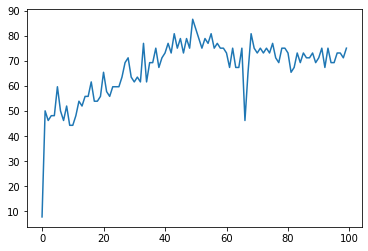

86.53846153846155

In [49]:
plt.plot(range(num),percent_correct)
plt.show()
max(percent_correct) # max is around 50 ms.

In [27]:
# Find best three_quarters value. .6 --> .8?

#start_time = time()

num = [.6, .61, .62, .63, .64, .65, .66, .67, .68, .69, .7, .71, .72, .73, .74, .75, .76, .77, .78, .79, 8]

percent_correct = np.zeros(len(num))

def features2(array, three_quarters_percent):
    len_dataset, _, number_of_columns = np.shape(array)
    number_of_features = 1
    condensed_data = np.zeros((len_dataset,number_of_features,number_of_columns))
    for j in range(72):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((number_of_features,number_of_columns),dtype=np.float64)
        for i in range(number_of_columns):
            column = data_point[:,i]
            D[0,i] = three_quarters(column,three_quarters_percent)
        condensed_data[j]=D
        if np.mod(j,6) == 0:
            print(j, end=" ")
    return condensed_data

for i in num:
    featured_data = features2(data_no_acc,i) #for speed
    maxed_data = everything_max(featured_data)
    percent_correct[i] = make_model(maxed_data, 64)

0 6 12 18 24 30 36 42 48 54 60 66 Predicted labels = [3 3 1 1 2 2 3 3]
Correct labels =   [0 0 1 1 2 2 3 3]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Below is some Tensorflow practice stuff that I'm not currently working on but don't want to lose

batch_size = 12
train_dataset = tf.data.Dataset.from_tensor_slices(train)
test_dataset = tf.data.Dataset.from_tensor_slices(test)

In [ ]:
features, labels = (train, train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((features, labels)).repeat().batch(12)

features, labels = (test, test_labels)
test_dataset = tf.data.Dataset.from_tensor_slices((features, labels)).repeat().batch(12)

In [ ]:
train_iter = train_dataset.__iter__()
test_iter = test_dataset.__iter__()

train_x, train_y = train_iter.get_next()
test_x, test_y = test_iter.get_next()

In [ ]:
list(test_dataset.as_numpy_iterator())

In [ ]:
features, labels = next(iter(train_dataset))

In [ ]:
test_dataset

In [ ]:
test_dataset.values()

In [ ]:
def pack_features_vector(features, labels):
    #Pack the features into a single array.
    features = tf.stack(list(features, axis=1))
    return features, labels

In [ ]:
train_dataset = train_dataset.map(pack_features_vector)

In [ ]:
# # make a simple model
# net = tf.keras.layers.Dense(train_x, 8) # pass the first value from iter.get_next() as input
# net = tf.keras.layers.dense(net, 8)
# prediction = tf.layers.dense(net, 1)
# loss = tf.losses.mean_squared_error(prediction, train_y) # pass the second value from iter.get_net() as label
# train_op = tf.train.AdamOptimizer().minimize(loss)

In [ ]:
np.shape(train[1])

l0 = tf.keras.layers.Dense(units=1, input_shape=[1])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(units = 112016, input_shape=(None, 7001, 16)),
    #tf.keras.layers.Dense(units=112016, input_shape=(None, 7001, 16), activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 12
# train = train.repeat().shuffle(62).batch(BATCH_SIZE)
# test = test.batch(BATCH_SIZE)

In [ ]:
model.fit(train, epochs=1, steps_per_epoch=math.ceil(1))